In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import json
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import tensorflow.keras as keras
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import pandas as pd
import yaml
import neurite as ne
from glob import glob
from tqdm import tqdm_notebook as tqdm
import subtle.subtle_metrics as su_metrics
from subtle.subtle_preprocess import apply_reg_transform, zoom_iso, register_im


from voxelmorph.tf.networks import AIRNet, Transform, VxmAffine, CascadedAffine, CascadedAffineMatrixOutput
from voxelmorph.tf.utils import invert_affine, affine_to_dense_shift, make_square_affine, compose as compose_tfms
from voxelmorph.tf.layers import SpatialTransformer
from scipy.ndimage import affine_transform
from scipy.ndimage.morphology import binary_fill_holes

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

def process_brats_vol(img_vol, pad=False, is_seg=False):
    img_vol = np.rot90(img_vol.transpose(2, 0, 1), axes=(1, 2), k=3)
    img_vol = img_vol[13:-14]
    
    if not is_seg:
        img_vol = img_vol / img_vol.mean()
        img_vol = np.interp(img_vol, (img_vol.min(), img_vol.max()), (0, 1))
    
    if pad:
        img_vol = np.pad(img_vol, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)
    return img_vol

def get_mse_for_case(case_data, aff_pred, tfm_model_gt, tfm_model_pred):
    img1, img2 = case_data['data']
    ip1 = img1[None, ..., None]
    ip2 = img2[None, ..., None]

    aff_sim = case_data['aff_mtx']
    aff_sim_4x4 = np.append(aff_sim, [[0, 0, 0, 1]], axis=0)
    aff_gt = np.linalg.inv(aff_sim_4x4)[:-1]
    
    img2_gt = tfm_model_gt.predict([ip2, aff_gt[None]])[0, ..., 0]
    img2_pred = tfm_model_pred.predict([ip2, aff_pred[None]])[0, ..., 0]
    
    diff_gt = img2_gt - img1
    diff_pred = img2_pred - img1
    
    return (np.square(diff_gt - diff_pred)).mean(axis=None)

def get_best_ckp(exp_path, exp_id):
    print('Fetching best checkpoint file for {}...'.format(exp_id))
    fpath_ckps = sorted([f for f in glob('{}/{}/ckps/*.h5'.format(exp_path, exp_id))])
    if '{}/{}/ckps/0001.h5'.format(exp_path, exp_id) in fpath_ckps:
        ckp_interval = 1
    else:
        ckp_interval = 5
    last_ckp_num = int(fpath_ckps[-1].split('/')[-1].replace('.h5', ''))

    num_ckps = last_ckp_num // ckp_interval
    step_idxs = [i-1 for i in np.arange(ckp_interval, last_ckp_num + 1, ckp_interval)]

    log_path = '{}/{}/logs/tb'.format(exp_path, exp_id)
    num_files = len(glob('{}/*'.format(log_path)))

    tf_size_guidance = {
        'compressedHistograms': 0,
        'images': num_files,
        'scalars': last_ckp_num+1,
        'histograms': 0
    }

    event_acc = EventAccumulator(log_path, size_guidance=tf_size_guidance)
    event_acc.Reload()

    val_losses = [(v.step, v.value) for v in event_acc.Scalars('val_loss') if v.step in step_idxs]
    min_idx = np.argmin([v[1] for v in val_losses])

    ep_idx = (val_losses[min_idx][0] + 1)
    fpath_ckp = '{exp_path}/{exp_id}/ckps/{epoch:04d}.h5'.format(exp_path=exp_path, exp_id=exp_id, epoch=ep_idx)

    return fpath_ckp, ep_idx
    
def fetch_eval_models(config):
    model_dict = {
        'airnet': AIRNet,
        'unet': VxmAffine,
        'cascade': CascadedAffine
    }
    
    img_list = open(config['img_list'], 'r').read().split('\n')
    sample_data = np.load(img_list[0])['data']
    img_shape = sample_data.shape[1:]
    
    arch = config['arch']
    model_params = {
        'inshape': img_shape,
        'verbose': 1
    }
    
    if arch == 'unet':
        model_params['batch_norm'] = config['bnorm']
        model_params['constraint_params'] = config['constraint_params']
        model_params['enc_only'] = (config['network_mode'] == 'enc')
    
    eval_model = model_dict[arch](**model_params)
    
    tfm_model_gt = Transform(inshape=img_shape, affine=True, shift_center=False)
    tfm_model_pred = Transform(inshape=img_shape, affine=True)
    return eval_model, tfm_model_gt, tfm_model_pred
    
def get_model_pred(model, aff_model, case_data):
    data = case_data['data']
    ip1 = data[0][None, ..., None]
    ip2 = data[1][None, ..., None]
    
    pred_img = model.model.predict([ip2, ip1])[0, ..., 0]
    pred_aff = aff_model.predict([ip2, ip1])[0]
    
    return pred_img, pred_aff

def get_aff_model(model, fpath_ckp):
    if model.name == 'cc_affine':
        inshape = model.model.layers[0].output_shape[0][1:-1]
        aff_model = CascadedAffineMatrixOutput(inshape=inshape).model
    else:
        aff_layer = model.model.get_layer('{}_aff_mtx'.format(model.name))
        aff_model = Model(
            inputs=[model.model.layers[0].input, model.model.layers[1].input], 
            outputs=[aff_layer.output]
        )
    aff_model.load_weights(fpath_ckp, by_name=True)
    return aff_model

def plot_pred(case_data, reg, fpath=None, ref_prereg=None, sl=None):
    fixed, moving = case_data['data']
    
    sl_idx = sl if sl is not None else fixed.shape[0] // 2
    img1 = np.hstack([fixed[sl_idx], moving[sl_idx], reg[sl_idx]])
    
    diff1 = moving - fixed
    diff2 = reg - fixed
    diff3 = np.zeros_like(fixed)
    if ref_prereg is not None:
        diff3 = ref_prereg - fixed
    
    fig, axs = plt.subplots(2, 3)
    
    imgs = [
        (fixed[sl_idx], 'Fixed'), 
        (moving[sl_idx], 'Moving'), 
        (reg[sl_idx], 'Registered'), 
        (diff1[sl_idx], 'Diff(fixed, moving)'), 
        (diff2[sl_idx], 'Diff(fixed, registered)'),
        (diff3[sl_idx], 'Diff - BRATS prereg')
    ]
    k = 0
    for i in range(2):
        for j in range(3):
            axs[i, j].imshow(imgs[k][0])
            axs[i, j].axis('off')
            axs[i, j].set_title(imgs[k][1])
            k += 1
    fig.tight_layout()
    
    if fpath:
        plt.savefig(fpath)
        plt.clf()

        
def compute_dice(fpath_ref, cnum, case_data, pred, aff, pad_ref, tfm_models):
    seg_gt = process_brats_vol(
        nib.load('{}/{}/{}_seg.nii.gz'.format(fpath_ref, cnum, cnum)).get_fdata(), is_seg=True, pad=pad_ref
    )
    seg_gt = (seg_gt > 0).astype(np.uint8) #combine all tumor classes into one mask

    aff_pred = aff
    aff_sim = case_data['aff_mtx']
    
    seg_sim = tfm_models[0].predict([seg_gt[None, ..., None], aff_sim[None]])[0, ..., 0]
    seg_sim = (seg_sim > 0.9).astype(np.uint8)
    
    seg_pred = tfm_models[1].predict([seg_sim[None, ..., None], aff_pred[None]])[0, ..., 0]
    seg_pred = (seg_pred > 0.9).astype(np.uint8)
    
    dice_before = su_metrics.dice(seg_gt, seg_sim)
    dice_after = su_metrics.dice(seg_gt, seg_pred)
    return dice_before, dice_after

def get_sitk_tfm_obj(aff_params, fpath_ref_obj='/home/srivathsa/projects/studies/gad/vmorph/sitk_ref_pmap.json'):
    sitk_pmap = sitk.GetDefaultParameterMap('affine')
    ref_obj = json.loads(open(fpath_ref_obj, 'r').read())
    
    for k, v in ref_obj.items():
        sitk_pmap[k] = tuple(v)
    
    tfm_params = aff_params.T.reshape(1, -1)[0].astype(str)
    sitk_pmap['TransformParameters'] = tfm_params
    
    return tuple([sitk_pmap])
    

def eval_vmorph_affine(exp_path, exp_id, fpath_ref, ref_sfxs=['t1', 't1ce'], pad_ref=True, config_name='', 
                      compute_metrics=True):
    exp_dir = os.path.join(exp_path, exp_id)
    fpath_ckp, ep_id = get_best_ckp(exp_path, exp_id)

    print('Evaluating with {}...'.format(fpath_ckp))

    get_cnum = lambda f: f.split('/')[-1].replace('.npz', '')
    
    fname_config = 'config.yaml' if not config_name else 'config_{}.yaml'.format(config_name)
    config = yaml.load(open('{}/{}'.format(exp_dir, fname_config), 'r').read())
    model, tfm_model_gt, tfm_model_pred = fetch_eval_models(config)

    model.model.load_weights(fpath_ckp, by_name=config['arch']=='cascade')
    aff_model = get_aff_model(model, fpath_ckp)
    
    dname_eval = 'eval' if not config_name else 'eval_{}'.format(config_name)
    fpath_eval = os.path.join(exp_dir, dname_eval)
    fpath_preds = os.path.join(fpath_eval, 'preds')
    fpath_plots = os.path.join(fpath_eval, 'plots')
    fpath_metrics = os.path.join(fpath_eval, 'metrics.csv')

    if not os.path.exists(fpath_eval):
        os.makedirs(fpath_eval)
        os.makedirs(fpath_preds)
        os.makedirs(fpath_plots)

    fpath_cases = sorted([c for c in open(config['val_img_list'], 'r').read().split('\n')
                         if len(c) > 0])
    print('Running evaluation on {} cases...'.format(len(fpath_cases)))

    print('Saving preds to {}...'.format(fpath_preds))

    metrics = []

    tfm_model_seg1 = None
    tfm_model_seg2 = None

    for fpath_case in tqdm(fpath_cases, total=len(fpath_cases)):
        case_data = np.load(fpath_case)

        if not tfm_model_seg1:
            tfm_model_seg1 = Transform(
                inshape=tuple(case_data['data'].shape[1:]), affine=True, interp_method='nearest', shift_center=False
            )

            tfm_model_seg2 = Transform(
                inshape=tuple(case_data['data'].shape[1:]), affine=True, interp_method='nearest', shift_center=True
            )

        cnum = get_cnum(fpath_case)
        pred, aff = get_model_pred(model, aff_model, case_data)
        np.savez('{}/{}.npz'.format(fpath_preds, cnum), pred=pred, aff=aff)
        
        fpath_cplot = os.path.join(fpath_plots, '{}.png'.format(cnum))
    
        if compute_metrics:
            metrics_obj = {'case': cnum}
            metrics_obj['mse'] = get_mse_for_case(case_data, aff, tfm_model_gt, tfm_model_pred)

            ref_prereg = None

            if fpath_ref is not None:
                ref_prereg = nib.load('{}/{}/{}_{}.nii.gz'.format(fpath_ref, cnum, cnum, ref_sfxs[1])).get_fdata()
                ref_prereg = process_brats_vol(ref_prereg, pad=pad_ref)

                metrics_obj['ssim_before'] = su_metrics.ssim(case_data['data'][1], ref_prereg)
                metrics_obj['ssim_after'] = su_metrics.ssim(pred, ref_prereg)

                metrics_obj['psnr_before'] = su_metrics.psnr(case_data['data'][1], ref_prereg)
                metrics_obj['psnr_after'] = su_metrics.psnr(pred, ref_prereg)

                dice_scores = compute_dice(fpath_ref, cnum, case_data, pred, aff, pad_ref, 
                                                   [tfm_model_seg1, tfm_model_seg2])
                metrics_obj['dice_before'] = dice_scores[0]
                metrics_obj['dice_after'] = dice_scores[1]
            metrics.append(metrics_obj)
        else:
            ref_prereg = np.zeros_like(pred)
        plot_pred(case_data, pred, fpath_cplot, ref_prereg)
    
    if len(metrics) > 0:
        df_metrics = pd.DataFrame(metrics)
        df_metrics.to_csv(fpath_metrics)
        print('Saving metrics to {}...'.format(fpath_metrics))

<Figure size 432x288 with 0 Axes>

In [2]:
eval_vmorph_affine(
    '/home/srivathsa/projects/studies/gad/vmorph/runs', '20220419_002828-brats_real',
    fpath_ref='/home/srivathsa/projects/brats_2021/data/val'
)

# eval_vmorph_affine(
#     '/home/srivathsa/projects/studies/gad/vmorph/runs/2021', '20211018_212059-brats',
#     fpath_ref=None, config_name='sford', compute_metrics=False
# )

Fetching best checkpoint file for 20220419_002828-brats_real...
Evaluating with /home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/ckps/0103.h5...
Instructions for updating:
Use fn_output_signature instead
Model: "functional_3"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
cc_affine_source_input (InputLayer) [(None, 128, 256, 256,  0                                                 
______________________________________________________________________________________________________________
cc_affine_target_input (InputLayer) [(None, 128, 256, 256,  0                                                 
______________________________________________________________________________________________________________
functional_1 (Functional)           (None, 128, 256, 256, 1 23504188     cc_affin

  0%|          | 0/125 [00:00<?, ?it/s]

Saving metrics to /home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/eval/metrics.csv...


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

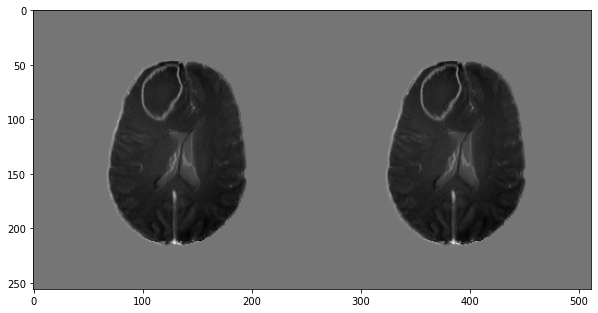

In [24]:
t1, t1ce = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats_real/val/BraTS2021_00006.npz')['data']

pred = np.load(
    '/home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/eval/preds/BraTS2021_00006.npz'
)['pred']
plt.imshow(np.hstack([pred[64] - t1[64], t1ce[64] - t1[64]]))

In [22]:
fpath_ckp = '/home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/ckps/0103.h5'
cmodel = CascadedAffine(inshape=(128, 256, 256), verbose=0)
cmodel.cascades[0].load_weights(fpath_ckp)

ValueError: You are trying to load a weight file containing 1 layers into a model with 146 layers.

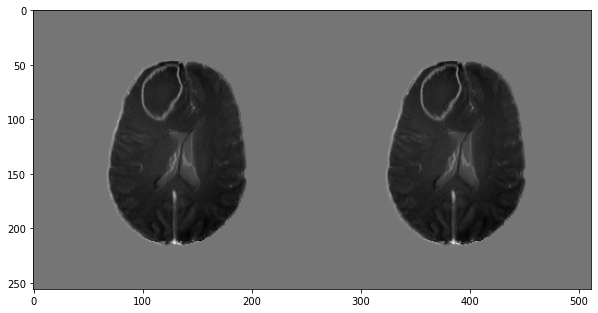

In [16]:
t1, t1ce = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats_real/val/BraTS2021_00006.npz')['data']

pred = cmodel.model.predict([t1ce[None, ..., None], t1[None, ..., None]])[0, ..., 0]
plt.imshow(np.hstack([t1ce[64] - t1[64], pred[64] - t1[64]]))

In [ ]:
anet_model = AIRNet(inshape=(128, 256, 256), verbose=1)
anet_model.model.load_weights(
    '/home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/ckps/0103.h5', by_name=True)

In [ ]:
t1_pre, t1_post = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/sford_low/val/Patient_0102.npz')['data']
exp_path = '/home/srivathsa/projects/studies/gad/vmorph/runs/2021/'
exp_id = '20211012_050145-brats_fl'
fpath_ckp, _ = get_best_ckp(exp_path, exp_id)
print(fpath_ckp)
base_model = AIRNet(inshape=(128, 240, 240), verbose=0)
# base_model = VxmAffine(inshape=(128, 256, 256), enc_only=False, verbose=0)
base_model.model.load_weights(fpath_ckp)
# sf_pred = base_model.model.predict([t1_post[None, ..., None], t1_pre[None, ..., None]])[0, ..., 0]

In [ ]:
plt.imshow(np.hstack([t1_post[64] - t1_pre[64], sf_pred[64] - t1_pre[64]]))
# plt.imshow(np.hstack([t1_pre[64], t1_post[64], sf_pred[64]]))
plt.axis('off')

In [ ]:
t1_pre, _ = zoom_iso(data[1, :, 0], np.array([0.5, 0.4688, 0.4688]), np.array([1, 1, 1]))
t1_pre = t1_pre[24:-24]
t1_pre = np.pad(t1_pre, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)

t1_post, _ = zoom_iso(data[1, :, 1], np.array([0.5, 0.4688, 0.4688]), np.array([1, 1, 1]))
t1_post = t1_post[24:-24]
t1_post = np.pad(t1_post, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)
print(t1_pre.shape, t1_post.shape)

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/vmorph/runs'
data_path = '/home/srivathsa/projects/studies/gad/vmorph/data/brats/val'
exp_id = '20211012_035922-brats'

man_fails = ['BraTS2021_00066', 'BraTS2021_00099', 'BraTS2021_00312', 'BraTS2021_00349', 'BraTS2021_00391', 
             'BraTS2021_00707', 'BraTS2021_01333', 'BraTS2021_01471']

metrics_dict = pd.read_csv('{}/{}/eval/metrics_new.csv'.format(base_path, exp_id)).to_dict(orient='records')

val_fails = [d for d in metrics_dict if d['case'] == man_fails[2]]
print('{} fail cases'.format(len(val_fails)))

x_vals = []
y_vals = []

for vf in val_fails:
    pred_data = np.load('{}/{}/eval/preds/{}.npz'.format(base_path, exp_id, vf['case']))
    case_data = np.load('{}/{}.npz'.format(data_path, vf['case']))
    aff_gt = np.linalg.inv(np.append(case_data['aff_mtx'], [[0, 0, 0, 1]], axis=0))[:-1]
    aff = pred_data['aff']
    
    plt.imshow(case_data['data'][1, 40])
    break
#     print(vf['case'])
#     print(case_data['aff_mtx'])
#     print('------')
    
#     x_vals.append(np.abs(aff[0, -1] - aff_gt[0, -1]))
#     y_vals.append(vf['dice'])
#     print(vf['case'], vf['dice'], aff[0, -1], aff_gt[0, -1])

In [ ]:
# recompute Dice score alone

fpath_exp = '/home/srivathsa/projects/studies/gad/vmorph/runs/20211018_212059-brats'
fpath_data = '/home/srivathsa/projects/studies/gad/vmorph/data/brats/val'
fpath_ref = '/home/srivathsa/projects/brats_2021/data/val'
cases = sorted([f.split('/')[-1].replace('.npz', '') for f in glob('{}/*.npz'.format(fpath_data))])

df_metrics = pd.read_csv('{}/eval/metrics.csv'.format(fpath_exp))
dict_metrics = df_metrics.to_dict(orient='records')
tfm_model_seg1 = None

new_metrics = []

for cnum in tqdm(cases, total=len(cases)):
    case_data = np.load('{}/{}.npz'.format(fpath_data, cnum))
    if not tfm_model_seg1:
        tfm_model_seg1 = Transform(
            inshape=tuple(case_data['data'].shape[1:]), affine=True, interp_method='nearest', shift_center=False
        )
        
        tfm_model_seg2 = Transform(
            inshape=tuple(case_data['data'].shape[1:]), affine=True, interp_method='nearest', shift_center=True
        )
        
        
    pred_data = np.load('{}/eval/preds/{}.npz'.format(fpath_exp, cnum))
    pred = pred_data['pred']
    aff = pred_data['aff']
    
    dmet = [d for d in dict_metrics if d['case'] == cnum][0]
    del dmet['Unnamed: 0']
    del dmet['dice']
    new_dice = compute_dice(fpath_ref, cnum, case_data, pred, aff, True, [tfm_model_seg1, tfm_model_seg2])
    dmet['dice_before'] = new_dice[0]
    dmet['dice_after'] = new_dice[1]
    new_metrics.append(dmet)
pd.DataFrame(new_metrics).to_csv('{}/eval/metrics_new.csv'.format(fpath_exp))

In [4]:
# df_metrics = pd.read_csv('{}/eval/metrics.csv'.format(fpath_exp))
df_metrics = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/vmorph/runs/20220419_002828-brats_real/eval/metrics.csv'
)
df_metrics.mean()

,Unnamed: 0,case,mse,ssim_before,ssim_after,psnr_before,psnr_after,dice_before,dice_after
0,0,BraTS2021_00006,0.000599,0.915541,0.915541,32.179553,32.179553,0.933526,0.933526
1,1,BraTS2021_00022,0.000303,0.962804,0.962804,34.372052,34.372052,0.960071,0.960071
2,2,BraTS2021_00033,0.000325,0.943440,0.943440,34.581528,34.581528,0.943211,0.943211
3,3,BraTS2021_00035,0.000307,0.956076,0.956076,34.939912,34.939912,0.919403,0.919403
4,4,BraTS2021_00066,0.001595,0.826381,0.826381,28.102693,28.102693,0.637889,0.637889
...,...,...,...,...,...,...,...,...,...
120,120,BraTS2021_01637,0.000145,0.984793,0.984793,36.678761,36.678761,0.999436,0.999436
121,121,BraTS2021_01653,0.000349,0.940306,0.940306,33.962940,33.962940,0.904831,0.904831
122,122,BraTS2021_01658,0.000565,0.932614,0.932614,31.744440,31.744440,0.909079,0.909079
123,123,BraTS2021_01664,0.000861,0.922563,0.922563,30.571939,30.571939,0.935994,0.935994


In [ ]:
fpath_ref = '/home/srivathsa/projects/brats_2021/data/val'
cnum = 'BraTS2021_00136'

img_pre = process_brats_vol(nib.load('{}/{}/{}_t1.nii.gz'.format(fpath_ref, cnum, cnum)).get_fdata(), pad=True) 
img_gt = process_brats_vol(nib.load('{}/{}/{}_t1ce.nii.gz'.format(fpath_ref, cnum, cnum)).get_fdata(), pad=True)
seg_gt = process_brats_vol(nib.load('{}/{}/{}_seg.nii.gz'.format(fpath_ref, cnum, cnum)).get_fdata(), is_seg=True, pad=True)
seg_gt = (seg_gt > 0).astype(np.uint8)

pred_data = np.load(
    '/home/srivathsa/projects/studies/gad/vmorph/runs/20211012_035922-brats/eval/preds/{}.npz'.format(cnum)
)
aff_pred = pred_data['aff'].astype(np.float32)

case_data = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats/val/{}.npz'.format(cnum))

diff1 = img_gt - img_pre
diff2 = pred_data['pred'] - case_data['data'][0]
# plt.imshow(np.hstack([diff1[64], diff2[64]]))

aff_gt = case_data['aff_mtx']
aff_sim = case_data['aff_mtx'].astype(np.float32)
aff_pred_4x4 = np.append(aff_pred, [[0, 0, 0, 1]], axis=0)
aff_sim_4x4 = np.append(aff_sim, [[0, 0, 0, 1]], axis=0)
tfm_eff = np.matmul(aff_pred_4x4, aff_sim_4x4)[:-1]

# seg_pred = affine_transform(seg_gt, aff_sim)
# seg_pred = (seg_pred > 0.5).astype(np.uint8)

tfm_model1 = Transform(inshape=(128, 256, 256), affine=True, interp_method='nearest', shift_center=False)
seg_pred1 = tfm_model1.predict([seg_gt[None, ..., None], aff_sim[None]])[0, ..., 0]
seg_pred1 = (seg_pred1 > 0.9).astype(np.uint8)

tfm_model2 = Transform(inshape=(128, 256, 256), affine=True, interp_method='nearest')
seg_pred2 = tfm_model2.predict([seg_pred1[None, ..., None], aff_pred[None]])[0, ..., 0]
seg_pred2 = (seg_pred2 > 0.9).astype(np.uint8)

# seg_pred3 = tfm_model1.predict([seg_gt[None, ..., None], tfm_eff[None]])[0, ..., 0]
# seg_pred3 = (seg_pred3 > 0.5).astype(np.uint8)

# plt.imshow(np.hstack([seg_gt[64], seg_pred1[64]]))
plt.imshow(np.hstack([seg_gt[64], seg_pred2[64]]))

# sim_data = affine_transform(img_gt, )
# plt.imshow(np.hstack([img_pre[64], sim_data[64]]))
print(su_metrics.dice(seg_gt, seg_pred1))


In [ ]:
# tmp = (seg_sim[0, ..., 0] > 0.5).astype(np.uint8)

# print(su_metrics.dice(seg_gt, seg_sim[0, ..., 0]))
# print(su_metrics.dice(seg_gt, seg_pred))

print(aff_sim)
print(aff_pred)

In [ ]:
pmap = sitk.GetDefaultParameterMap('affine')
im_reg, params = register_im(case_data['data'][0], case_data['data'][1], param_map=pmap)

In [ ]:
aff_pred_mod = aff_pred.copy()
aff_pred_mod[:, -1] = np.linalg.inv(aff_sim_4x4)[:-1][:, -1]

tfm = get_sitk_tfm_obj(aff_gt)
tfm1 = get_sitk_tfm_obj(aff_pred_mod)

seg_r = apply_reg_transform(seg_gt, [1, 1, 1], tfm1)
seg_r = (seg_r > 0.9).astype(np.uint8)

plt.imshow(np.hstack([seg_gt[64], seg_r[64]]))
print(su_metrics.dice(seg_gt, seg_r))

In [ ]:
pred_data = np.load('/home/srivathsa/projects/studies/gad/vmorph/runs/20211007_215148-brats/eval/preds/BraTS2021_00006.npz')
pred = pred_data['pred']

ip1, ip2 = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats/val/BraTS2021_00006.npz')['data']

ref_pre = nib.load('/home/srivathsa/projects/brats_2021/data/val/BraTS2021_00006/BraTS2021_00006_t1.nii.gz').get_fdata()
ref_data = nib.load('/home/srivathsa/projects/brats_2021/data/val/BraTS2021_00006/BraTS2021_00006_t1ce.nii.gz').get_fdata()

ref_pre = process_brats_vol(ref_pre, pad=True)
ref_data = process_brats_vol(ref_data, pad=True)

diff1 = pred-ip1
diff2 = ref_data - ref_pre
plt.imshow(np.hstack([diff1[64]]))

# print(su_metrics.ssim(pred, ref_data))
# print(su_metrics.psnr(pred, ref_data))

# print(su_metrics.ssim(ip2, ref_data))
# print(su_metrics.psnr(ip2, ref_data))

In [ ]:
data_path = '/home/srivathsa/projects/studies/gad/vmorph/data/brats/val'
exp_path = '/home/srivathsa/projects/studies/gad/vmorph/runs'
exp_id = '20211007_213819-brats'
ckp_id = '0130'
# calc_aff_mse(data_path, exp_path, exp_id)

In [ ]:
case_num = 'BraTS2021_00006'

fpath_ckp = '{}/{}/ckps/{}.h5'.format(exp_path, exp_id, ckp_id)

base_model = AIRNet(inshape=(128, 256, 256), verbose=0)
base_model.model.load_weights(fpath_ckp)

aff_layer = base_model.model.get_layer('airnet_aff_mtx')
tmp_model = Model(
    inputs=[base_model.model.layers[0].input, base_model.model.layers[1].input], 
    outputs=aff_layer.output
)
tmp_model.load_weights(fpath_ckp, by_name=True)

In [ ]:
sf_pred = base_model.model.predict([t1_post[None, ..., None], t1_pre[None, ..., None]])[0, ..., 0]
print(sf_pred.shape)

In [ ]:
plt.imshow(np.hstack([t1_post[64] - t1_pre[64], sf_pred[64] - t1_pre[64]]))

In [ ]:
case_data = np.load('{}/{}.npz'.format(data_path, case_num))
img1, img2 = case_data['data']
ip1 = img1[None, ..., None]
ip2 = img2[None, ..., None]

aff_sim = case_data['aff_mtx']
aff_gt = K.eval(invert_affine(aff_sim))

aff_pred = tmp_model.predict([ip2, ip1])[0]
pred_img = base_model.model.predict([ip2, ip1])[0, ..., 0]

In [ ]:
tfm_model1 = Transform(inshape=(128, 256, 256), affine=True, shift_center=False)
tfm_model2 = Transform(inshape=(128, 256, 256), affine=True)

In [ ]:
# img2_gt = affine_transform(img2, aff_gt)
img2_gt = tfm_model1.predict([ip2, aff_gt[None]])[0, ..., 0]

# img2_pred = affine_transform(img2, aff_pred)
img2_pred = tfm_model2.predict([ip2, aff_pred[None]])[0, ..., 0]

In [ ]:
diff_pre = img2 - img1
diff_gt = img2_gt - img1
diff_pred = img2_pred - img1

plt.imshow(np.hstack([diff_pre[64], diff_gt[64], diff_pred[64]]))
# plt.imshow(np.hstack([aff_gt, aff_pred]))

In [ ]:
aff_gt

In [ ]:
aff_pred

In [ ]:
np.append(aff_sim, [[1, 0, 0, 0]], axis=0)